In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

calendrier_challenge = pd.read_parquet("challenge_data/calendrier_challenge.parquet")
questionnaire = pd.read_parquet("challenge_data/questionnaire.parquet")
consos_challenge = pd.read_parquet("challenge_data/consos_challenge.parquet")
temperatures = pd.read_parquet("challenge_data/temperatures.parquet")

min_date = datetime.datetime(2009,7,15)
max_date=datetime.datetime(2011,1,1)
all_clients = list(set(consos_challenge["id_client"]))
day = datetime.datetime(2011,1,2)-datetime.datetime(2011,1,1)
print(len(all_clients))

615


Methode 1 : correlation à l'échelle individuelle

Pour un individu donné, deux signaux sont dit proches s'ils sont fortement correlés. 

Le signal prédit est alors le signal fortement correlé avec les signaux précédent

In [61]:
def centered(X):
    return (X-X.mean())/np.mean((X-X.mean())**2)**0.5

def correlation(big_signal,small_signal):
    n_small = len(small_signal)
    n_big = len(big_signal)
    result = []
    for i in range(n_big-n_small):
        centered_signal = centered(big_signal[i:n_small+i])
        result.append(np.sum(small_signal*centered_signal))
    return np.array(result)



def load_signal(id_client,min_time,max_time):

    data = consos_challenge[consos_challenge["id_client"]==id_client]
    data1 = data[data["horodate"]>min_time]
    return data1[data1["horodate"]<=max_time].puissance_W


La prédiction correspond au signal le plus correlé

2048
4100
4104
4106
6154
2061
6157
6163
6165
6166
2.367680014619929
1.0366375822993021
0.847 1.199


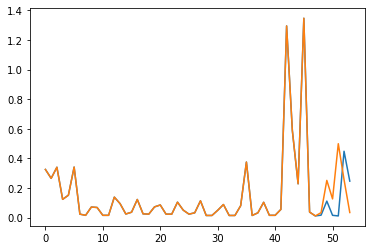

In [66]:
def predict(start_time,end_time,id_client, delta_time):
    length_to_predict = (end_time-start_time).seconds//1800
    delta_i = delta_time.days*48
    big_signal = np.array(load_signal(id_client, min_date, start_time-delta_time))
    signal_to_use = np.array(load_signal(id_client, start_time-delta_time, start_time))
    signal_to_use = centered(signal_to_use)
    corr = correlation(big_signal,signal_to_use)
    id_max = np.argmax(corr)
    return big_signal[id_max+delta_i:id_max+delta_i+length_to_predict]

y_predict = []
y_test = []
for id in all_clients[:10]:
    print(id)
    for n_day in range(5):
        start_time = datetime.datetime(2010,9,20,18)+3*n_day*day
        end_time = datetime.datetime(2010,9,20,21)+3*n_day*day
        delta_time = 7*day
        true_signal = np.array(load_signal(id,start_time,end_time))
        signal_predict = predict(start_time,end_time,id,delta_time)
        signal_previous = np.array(load_signal(id,start_time-day,start_time))
        y_predict.append(signal_predict)
        y_test.append(true_signal)

y_test = np.array(y_test)
y_predict = np.array(y_predict)
print(np.mean(np.abs(y_test.sum(axis=1)-y_predict.sum(axis=1))))
print(np.mean((y_test-y_predict)**2))
print(np.sum(true_signal),np.sum(signal_predict))
plt.plot(list(signal_previous)+list(true_signal))
plt.plot(list(signal_previous)+list(signal_predict))
plt.show()


La prédiction correspond à tous les signaux corrélées au dela d 'un certain seuil.

2048
4100
4104
4106
6154
2061
6157
6163
6165
6166
1.8170581881747185
0.4256077838707139
9.612999999999998 7.7036


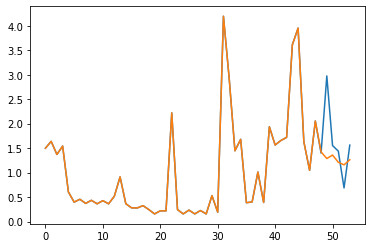

5.289 6.912249999999999


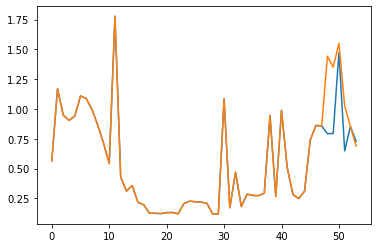

2.619 3.2721999999999998


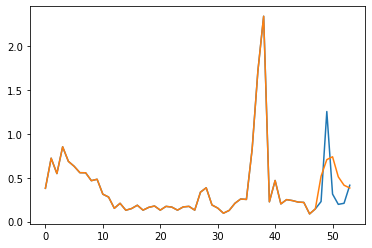

1.7989999999999997 1.2751428571428571


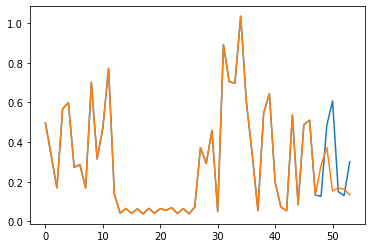

2.7190000000000003 2.3497500000000002


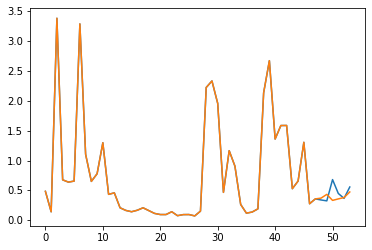

1.773 2.8028000000000004


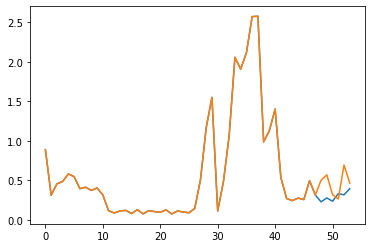

4.529 4.031499999999999


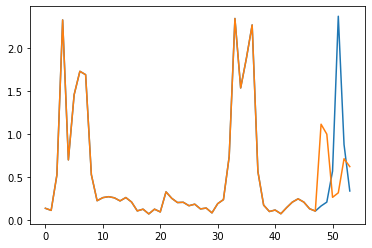

18.998 8.466666666666669


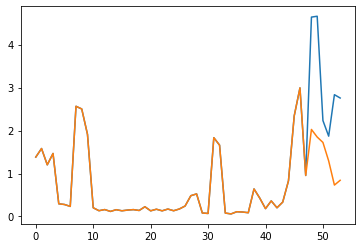

1.402 1.8093793103448275


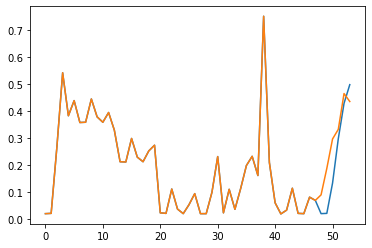

4.038 5.460999999999999


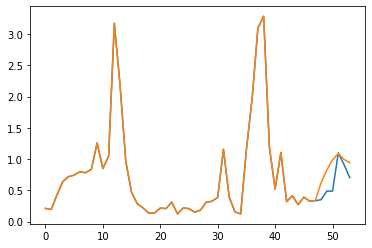

In [73]:
def predict_multi(start_time,end_time,id_client, delta_time,coef):
    delta_i = delta_time.days*48
    length_to_predict = (end_time-start_time).seconds//1800
    big_signal = np.array(load_signal(id_client, min_date,start_time-delta_time))
    signal_to_use = np.array(load_signal(id_client, start_time-delta_time,start_time))
    signal_to_use = centered(signal_to_use)
    corr = correlation(big_signal,signal_to_use)
    id_max = np.argmax(corr)
    corr_max = corr[id_max]

    n_signals=0
    mean_signal = big_signal[:length_to_predict]*0
    for id,co in enumerate(corr):
        if co>corr_max*coef and len(big_signal[id+delta_i:id+delta_i+length_to_predict])==len(mean_signal):
            n_signals+=1
            mean_signal = mean_signal + big_signal[id+delta_i:id+delta_i+length_to_predict]
    return mean_signal/n_signals


y_predict = []
y_test = []
for id in all_clients[:10]:
    print(id)
    for n_day in range(50):
        start_time = datetime.datetime(2010,9,20,18)+n_day*day
        end_time = datetime.datetime(2010,9,20,21)+n_day*day
        delta_time = 7*day
        true_signal = np.array(load_signal(id,start_time,end_time))
        signal_predict = predict_multi(start_time,end_time,id,delta_time,0.9)
        signal_previous = np.array(load_signal(id,start_time-day,start_time))
        y_predict.append(signal_predict)
        y_test.append(true_signal)

y_test = np.array(y_test)
y_predict = np.array(y_predict)
print(np.mean(np.abs(y_test.sum(axis=1)-y_predict.sum(axis=1))))
print(np.mean((y_test-y_predict)**2))

for i in range(20,30):
    id = all_clients[i]
    start_time = datetime.datetime(2010,9,20,18)
    end_time = datetime.datetime(2010,9,20,21)
    delta_time = 7*day
    true_signal = np.array(load_signal(id,start_time,end_time))
    signal_predict = predict_multi(start_time,end_time,id,delta_time,0.9)
    signal_previous = np.array(load_signal(id,start_time-day,start_time))
    print(np.sum(true_signal),np.sum(signal_predict))
    plt.plot(list(signal_previous)+list(true_signal))
    plt.plot(list(signal_previous)+list(signal_predict))
    plt.show()